# Configuration, Utils, Libraries.

install libraries

In [ ]:
!pip install mlflow
!pip install ensure
!pip install Flask
!pip install Flask-Cors
!pip install pyngrok
!pip install dagshub


import libraries

In [ ]:
import tensorflow as tf
import pandas
import gdown
import mlflow
import mlflow.keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import ensure
import joblib
import scipy
from flask import Flask, request, jsonify, render_template
import flask_cors
from dataclasses import dataclass
from pathlib import Path
import os
from box.exceptions import BoxValueError
import json
import joblib
from ensure import ensure_annotations
from box import ConfigBox
from typing import Any
import base64
import random
import shutil
import zipfile
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from urllib.parse import urlparse
from pyngrok import ngrok
import dagshub
import math


configuration

In [ ]:
config = {
    "artifacts_root": "artifacts",

    "data_ingestion": {
        "root_dir": "artifacts/data_ingestion",
        "source_URL": "https://drive.google.com/file/d/1RempNSBTxQB-TUCi1VtXVbHCcVW3vFWP/view?usp=share_link",
        "local_data_file": "artifacts/data_ingestion/dataset.zip",
        "unzip_dir": "artifacts/data_ingestion"
    },

    "prepare_base_model": {
        "root_dir": "artifacts/prepare_base_model",
        "base_model_path": "artifacts/prepare_base_model/base_model.h5",
        "updated_base_model_path": "artifacts/prepare_base_model/base_model_updated.h5"
    },

    "training": {
        "root_dir": "artifacts/training",
        "trained_model_path": "artifacts/training/model.h5"
    }
}

params = {
    "AUGMENTATION": True,
    "IMAGE_SIZE": [224, 224, 3],  # as per VGG 16 model
    "BATCH_SIZE": 16,
    "INCLUDE_TOP": False,
    "EPOCHS": 200,
    "CLASSES": 14,
    "WEIGHTS": "imagenet",
    "LEARNING_RATE": 0.015,
    "PRETRAINED": True
}

dagshub.init(repo_owner='Islamhany1', repo_name='Clothes-Classification-MLops', mlflow=True)

os.environ['MLFLOW_TRACKING_USERNAME'] = 'Islamhany1'  # Your DagsHub username
os.environ['MLFLOW_TRACKING_PASSWORD'] = 'e66d5178f19891e622e06e6d1366e61786bee186'  # Your personal access token



# dataclass decorator automatically generates an __init__ method for the class based on the fields you define
# Setting frozen=True ensures that the generated __init__ method won't allow modifications to these attributes after instantiation.
@dataclass(frozen=True)
class DataIngestionConfig:
    root_dir: Path
    source_URL: str
    local_data_file: Path
    unzip_dir: Path

@dataclass(frozen=True)
class PrepareBaseModelConfig:
    root_dir: Path
    base_model_path: Path
    updated_base_model_path: Path
    params_image_size: list
    params_learning_rate: float
    params_include_top: bool
    params_weights: str
    params_classes: int

@dataclass(frozen=True)
class TrainingConfig:
    root_dir: Path
    trained_model_path: Path
    updated_base_model_path: Path
    training_data: Path
    params_epochs: int
    params_batch_size: int
    params_is_augmentation: bool
    params_image_size: list
    params_learning_rate: float

@dataclass(frozen=True)
class EvaluationConfig:
    path_of_model: Path
    training_data: Path
    all_params: dict
    mlflow_uri: str
    params_image_size: list
    params_batch_size: int




Initialized MLflow to track repo "Islamhany1/Clothes-Classification-MLops"

Repository Islamhany1/Clothes-Classification-MLops initialized!

utils functions.

In [ ]:
@ensure_annotations # @ensure_annotations: This decorator is used to enforce type checking based on function annotations.
def create_directories(path_to_directories: list, verbose=True):
    """create list of directories

    Args:
        path_to_directories (list): list of path of directories
        ignore_log (bool, optional): ignore if multiple dirs is to be created. Defaults to False.
    """
    for path in path_to_directories:
        os.makedirs(path, exist_ok=True)



@ensure_annotations
def save_json(path: Path, data: dict):
    """save json data

    Args:
        path (Path): path to json file
        data (dict): data to be saved in json file
    """
    with open(path, "w") as f:
        json.dump(data, f, indent=4)




@ensure_annotations
def load_json(path: Path) -> ConfigBox:
    """load json files data

    Args:
        path (Path): path to json file

    Returns:
        ConfigBox: data as class attributes instead of dict
    """
    with open(path) as f:
        content = json.load(f)


    return ConfigBox(content)


@ensure_annotations
def save_bin(data: Any, path: Path):
    """save binary file

    Args:
        data (Any): data to be saved as binary
        path (Path): path to binary file
    """
    joblib.dump(value=data, filename=path)


@ensure_annotations
def load_bin(path: Path) -> Any:
    """load binary data

    Args:
        path (Path): path to binary file

    Returns:
        Any: object stored in the file
    """
    data = joblib.load(path)
    return data


@ensure_annotations
def get_size(path: Path) -> str:
    """get size in KB

    Args:
        path (Path): path of the file

    Returns:
        str: size in KB
    """
    size_in_kb = round(os.path.getsize(path) / 1024)
    return f"~ {size_in_kb} KB"


# This function decodes a Base64-encoded string and saves the resulting binary data as an image file (.png).
def decodeImage(imgstring, fileName):
    imgdata = base64.b64decode(imgstring)
    with open(fileName, 'wb') as f:
        f.write(imgdata)
        f.close()



def encodeImageIntoBase64(croppedImagePath):
    with open(croppedImagePath, "rb") as f:
        return base64.b64encode(f.read())



# Data Ingestion

Data Ingestion Class.

In [ ]:



class DataIngestion:
    def __init__(self, config: DataIngestionConfig):
        self.config = config

    def download_file(self) -> str:
        '''
        Fetch data from the url
        '''

        try:
            dataset_url = self.config.source_URL
            zip_download_dir = self.config.local_data_file
            os.makedirs("artifacts/data_ingestion", exist_ok=True)

            file_id = dataset_url.split("/")[-2]
            prefix = 'https://drive.google.com/uc?/export=download&id='
            gdown.download(prefix + file_id, zip_download_dir)


        except Exception as e:
            raise e

    def extract_zip_file(self):
        """
        zip_file_path: str
        Extracts the zip file into the data directory
        Function returns None
        """
        unzip_path = self.config.unzip_dir
        os.makedirs(unzip_path, exist_ok=True)
        with zipfile.ZipFile(self.config.local_data_file, 'r') as zip_ref:
            zip_ref.extractall(unzip_path)

    def split_data(self, item_folder, train_dir, val_dir, test_dir, train_split, val_split):
        files = os.listdir(item_folder)
        files = [f for f in files if os.path.isfile(os.path.join(item_folder, f))]
        random.shuffle(files)

        # Determine split sizes
        train_size = int(len(files) * train_split)
        val_size = int(len(files) * val_split)

        # Split files into training, validation, and test sets
        train_files = files[:train_size]
        val_files = files[train_size:train_size + val_size]
        test_files = files[train_size + val_size:]

        # Create category folders in each split directory
        category = os.path.basename(item_folder)
        os.makedirs(os.path.join(train_dir, category), exist_ok=True)
        os.makedirs(os.path.join(val_dir, category), exist_ok=True)
        os.makedirs(os.path.join(test_dir, category), exist_ok=True)

        # Move files
        for file in train_files:
            shutil.move(os.path.join(item_folder, file), os.path.join(train_dir, category, file))

        for file in val_files:
            shutil.move(os.path.join(item_folder, file), os.path.join(val_dir, category, file))

        for file in test_files:
            shutil.move(os.path.join(item_folder, file), os.path.join(test_dir, category, file))

    def delete_folders_not_enough_data(self):
        # Path to the directory you want to delete
        directory_to_delete = ['Blouse', 'Body', 'Skip', 'Top']  # Change this to your directory path
        base_dir = Path(Path.cwd() / 'artifacts/data_ingestion/dataset')
        starting_paths = [Path.joinpath(base_dir, 'training_data'), Path.joinpath(base_dir, 'test_data'), Path.joinpath(base_dir, 'validation_data')]
        # Check if the directory exists
        # Use shutil.rmtree() to delete the directory and its contents
        for starting_path in starting_paths:
            for directory in directory_to_delete:
                if os.path.exists(os.path.join(starting_path, directory)):
                    shutil.rmtree(os.path.join(starting_path, directory))
                    print(f"Directory '{directory}' has been deleted from {starting_path}.")
                else:
                    print(f"Directory '{directory}' does not exist in {starting_path}.")

    def delete_empty_folders(self, path: Path):
        # Recursively go through all directories
        for folder in path.iterdir():
            if folder.is_dir():
                self.delete_empty_folders(folder)  # Recursively check subdirectories
                # Remove the folder if it's empty
                if not any(folder.iterdir()):  # `any(folder.iterdir())` returns False if the folder is empty
                    folder.rmdir()
                    print(f"Deleted empty folder: {folder}")

    def data_augmentation(self):

        params_box = ConfigBox(params)

        # Define paths to your directories
        train_dir = Path(Path.cwd() / 'artifacts/data_ingestion/dataset/training_data')
        test_dir = Path(Path.cwd() / 'artifacts/data_ingestion/dataset/test_data')
        val_dir = Path(Path.cwd() / 'artifacts/data_ingestion/dataset/validation_data')

        image_size = (224, 224)

        # Create ImageDataGenerator objects for augmentation and rescaling

        # Augmentation for training data
        train_datagen = ImageDataGenerator(
            rescale=1. / 255,  # Normalize pixel values to [0, 1]
            rotation_range=30,  # Rotate images randomly within 30 degrees
            width_shift_range=0.2,  # Shift images horizontally by 20% of the width
            height_shift_range=0.2,  # Shift images vertically by 20% of the height
            shear_range=0.2,  # Shear angle for augmentation
            zoom_range=0.2,  # Random zoom into images by 20%
            horizontal_flip=True,  # Flip images horizontally
            fill_mode='nearest',  # Fill empty pixels after a transformation

        )

        # Rescale validation and test data (no augmentation)
        val_test_datagen = ImageDataGenerator(rescale=1. / 255)

        # Load and augment training data
        train_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=image_size,  # ResNet expects 224x224 input size
            batch_size=params_box.BATCH_SIZE,
            class_mode='categorical',  # Use 'categorical' for multi-class classification
            shuffle=True
        )


        # Load validation data (no augmentation)
        validation_generator = val_test_datagen.flow_from_directory(
            val_dir,
            target_size=image_size,
            batch_size=params_box.BATCH_SIZE,
            class_mode='categorical'
        )

        # Load test data (no augmentation)
        test_generator = val_test_datagen.flow_from_directory(
            test_dir,
            target_size=image_size,
            batch_size=params_box.BATCH_SIZE,
            class_mode='categorical',
            shuffle=False  # Don't shuffle test data for accurate results
        )

        self.train_generator = train_generator
        self.validation_generator = validation_generator
        self.test_generator = test_generator



    def visualise_data_after_augmentation(self):

        images, labels = next(self.train_generator)

        # Plot the first 5 images in the batch with their augmentations
        plt.figure(figsize=(10, 10))
        for i in range(5):
            plt.subplot(1, 5, i + 1)
            plt.imshow(images[i])
            plt.axis('off')  # Hide the axes
            plt.title(f'Image {i+1}')
            image_size = images[i].shape[:2]  # Height and width
            plt.title(f'{image_size[1]}x{image_size[0]}')  # Width x Height

        plt.show()


Starting The Data Ingestion Stage.

>>>>>> stage Data Ingestion stage started <<<<<<
Directory 'Blouse' does not exist in /content/artifacts/data_ingestion/dataset/training_data.
Directory 'Body' does not exist in /content/artifacts/data_ingestion/dataset/training_data.
Directory 'Skip' does not exist in /content/artifacts/data_ingestion/dataset/training_data.
Directory 'Top' does not exist in /content/artifacts/data_ingestion/dataset/training_data.
Directory 'Blouse' does not exist in /content/artifacts/data_ingestion/dataset/test_data.
Directory 'Body' does not exist in /content/artifacts/data_ingestion/dataset/test_data.
Directory 'Skip' does not exist in /content/artifacts/data_ingestion/dataset/test_data.
Directory 'Top' does not exist in /content/artifacts/data_ingestion/dataset/test_data.
Directory 'Blouse' does not exist in /content/artifacts/data_ingestion/dataset/validation_data.
Directory 'Body' does not exist in /content/artifacts/data_ingestion/dataset/validation_data.
Directory 'Skip' does not exist in /con

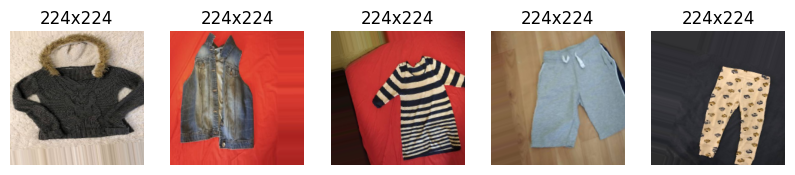

>>>>>> stage Data Ingestion stage completed <<<<<<

x==========x


In [ ]:
STAGE_NAME = "Data Ingestion stage"

class DataIngestionTrainingPipeline:
    def __init__(self):
        pass

    def main(self):
        # create data ingestion config.

        data_config_box = ConfigBox(config)
        params_box = ConfigBox(params)

        create_directories([data_config_box.artifacts_root])
        data_ingestion_config = DataIngestionConfig(
            root_dir=data_config_box.data_ingestion.root_dir,
            source_URL=data_config_box.data_ingestion.source_URL,
            local_data_file=data_config_box.data_ingestion.local_data_file,
            unzip_dir=data_config_box.data_ingestion.unzip_dir
        )
        # create data ingestion.
        data_ingestion = DataIngestion(data_ingestion_config)
        # call data ingestion methods.
        base_dir = Path(Path.cwd() / 'artifacts/data_ingestion/dataset')

        if not base_dir.exists():
            data_ingestion.download_file()
            data_ingestion.extract_zip_file()

        train_dir = Path(Path.cwd() / 'artifacts/data_ingestion/dataset/training_data')
        test_dir = Path(Path.cwd() / 'artifacts/data_ingestion/dataset/test_data')
        val_dir = Path(Path.cwd() / 'artifacts/data_ingestion/dataset/validation_data')


        # Create directories for training, testing, and validation
        for split_dir in [train_dir, test_dir, val_dir]:
            os.makedirs(split_dir, exist_ok=True)

        # Define the split sizes
        train_split = 0.7
        val_split = 0.15
        test_split = 0.15

        # Loop through each category folder in the base directory
        for category_folder in os.listdir(base_dir):
            category_path = os.path.join(base_dir, category_folder)
            if os.path.isdir(category_path): #Ensure it's a directory
                data_ingestion.split_data(category_path, train_dir, val_dir, test_dir, train_split, val_split)

        # delete directories which do not contain enough data.
        data_ingestion.delete_folders_not_enough_data()
        # delete empty directories.
        data_ingestion.delete_empty_folders(base_dir)
        # apply data augmentation.
        data_ingestion.data_augmentation()
        # visualise data after augmentation.
        data_ingestion.visualise_data_after_augmentation()

        self.data_ingestion = data_ingestion





print(f">>>>>> stage {STAGE_NAME} started <<<<<<")
obj_data_ingestion = DataIngestionTrainingPipeline()
obj_data_ingestion.main()
print(f">>>>>> stage {STAGE_NAME} completed <<<<<<\n\nx==========x")



# Prepare Model

Building vgg16 from scratch

In [ ]:


def vgg16(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 5
    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Classification block
    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)
    x = Dense(4096, activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=x)

    return model

# Define model

device_name = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"
print("Using device:", device_name)

with tf.device(device_name):
    # Define model
    input_shape = (224, 224, 3)  # Adjust according to your dataset
    num_classes = 14  # Number of classes in your dataset
    model = vgg16(input_shape, num_classes)

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Model summary
    model.summary()


Using device: /GPU:0


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,317,902 (512.38 MB)

 Trainable params: 134,317,902 (512.38 MB)

 Non-trainable params: 0 (0.00 B)

Preparing Model Class

In [ ]:
class PrepareBaseModel:
    def __init__(self, config: PrepareBaseModelConfig):
        self.config = config
        self.model = None
        self.full_model = None

    # loads the pre-trained VGG16 model.
    def get_base_model(self):
        self.model = tf.keras.applications.vgg16.VGG16(
            input_shape=self.config.params_image_size,
            weights=self.config.params_weights,
            include_top=self.config.params_include_top # include_top=False: This removes the final fully connected layers, leaving only the convolutional base.
        )


        self.save_model(path=self.config.base_model_path, model=self.model)


    # Modifies the base VGG16 by adding a custom classification head.
    def prepare_full_model(self, model, classes, freeze_all, freeze_till, learning_rate):
        if freeze_all:  # to freeze all layers
            for layer in model.layers:
                layer.trainable = False
        elif (freeze_till is not None) and (freeze_till > 0):  # freeze only some of them
            for layer in model.layers[:-freeze_till]:
                layer.trainable = False

        flatten_in = tf.keras.layers.Flatten()(self.model.output)  # Now pass the tensor to Flatten
        prediction = tf.keras.layers.Dense(
            units=14,
            activation="softmax"
        )(flatten_in)

        self.full_model = tf.keras.models.Model(
            inputs=self.model.input,
            outputs=prediction
        )


        self.full_model.summary()
        return self.full_model

    def updated_base_model(self):
        self.full_model = self.prepare_full_model(
            model=self.model,
            classes=self.config.params_classes,
            freeze_all=True,
            freeze_till=None,
            learning_rate=self.config.params_learning_rate
        )

        self.save_model(path=self.config.updated_base_model_path, model=self.model)

    def save_model(self,path: Path, model: tf.keras.Model):
        model.save(path)


Loading The Pre-trained model

In [ ]:


STAGE_NAME = "Prepare base model"


class PrepareBaseModelTrainingPipeline:
    def __init__(self):
        pass


    def main(self):
        # create prepare base model config.

        data_config_box = ConfigBox(config)
        params_box = ConfigBox(params)

        prepare_base_model_config = PrepareBaseModelConfig(
            root_dir=Path(data_config_box.prepare_base_model.root_dir),
            base_model_path=Path(data_config_box.prepare_base_model.base_model_path),
            updated_base_model_path=Path(data_config_box.prepare_base_model.updated_base_model_path),
            params_image_size=params_box.IMAGE_SIZE,
            params_learning_rate=params_box.LEARNING_RATE,
            params_include_top=params_box.INCLUDE_TOP,
            params_weights=params_box.WEIGHTS,
            params_classes=params_box.CLASSES
        )
        # create base model using the base model config.
        prepare_base_model = PrepareBaseModel(config=prepare_base_model_config)
        # call the methods.
        prepare_base_model.get_base_model()
        prepare_base_model.updated_base_model()


print(f"*******************")
print(f">>>>>> stage {STAGE_NAME} started <<<<<<")
obj_prepare_model = PrepareBaseModelTrainingPipeline()
obj_prepare_model.main()
print(f">>>>>> stage {STAGE_NAME} completed <<<<<<\n\nx==========x")



*******************
>>>>>> stage Prepare base model started <<<<<<


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 14)                  │         351,246 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 15,065,934 (57.47 MB)

 Trainable params: 351,246 (1.34 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

>>>>>> stage Prepare base model completed <<<<<<

x==========x


# Training The model

Train Model Class

In [ ]:


class Training:
    def __init__(self, config: TrainingConfig):
        self.config = config

    def get_updated_model(self):

        self.model = tf.keras.models.load_model(
        self.config.updated_base_model_path
        )

        # Concatenate the outputs if there are multiple
        if isinstance(self.model.output, list):
            # Concatenate the output tensors along the channel dimension (axis=-1)
            x = tf.keras.layers.concatenate(self.model.output, axis=-1)
        else:
            x = self.model.output

        # Apply GlobalAveragePooling2D to the concatenated output
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        # Add a Dense layer with 14 units and softmax activation for classification
        output = tf.keras.layers.Dense(14, activation='softmax')(x)
        # Create a new model with the modified output
        self.model = tf.keras.models.Model(inputs=self.model.input, outputs=output)



        # Compile the model after loading it.
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=self.config.params_learning_rate),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

    # for data augmentation and getting the data.
    def train_valid_generator(self):

        self.valid_generator = obj_data_ingestion.data_ingestion.validation_generator
        self.train_generator = obj_data_ingestion.data_ingestion.train_generator

    def save_model(self, path: Path, model: tf.keras.Model):
        model.save(path)

    def train(self):

        self.steps_per_epoch = math.ceil(self.train_generator.samples // self.train_generator.batch_size)
        self.validation_steps = math.ceil(self.valid_generator.samples // self.valid_generator.batch_size)

        #Call the model.fit with redirected stderr
        self.model.fit(
            self.train_generator,
            epochs=self.config.params_epochs,
            steps_per_epoch=self.steps_per_epoch,
            validation_steps=self.validation_steps,
            validation_data=self.valid_generator,
            verbose=1
        )

        self.save_model(path=self.config.trained_model_path, model=self.model)


Starting The Training Model Stage

In [ ]:


STAGE_NAME = "Training"


class ModelTrainingPipeline:
    def __init__(self):
        pass

    def main(self):
        # create training model config.

        data_config_box = ConfigBox(config)
        params_box = ConfigBox(params)

        training_config = TrainingConfig(
            root_dir=data_config_box.training.root_dir,
            trained_model_path=data_config_box.training.trained_model_path,
            updated_base_model_path=data_config_box.prepare_base_model.updated_base_model_path,
            training_data=Path(Path.cwd() / "artifacts/data_ingestion/dataset/training_data"),
            params_epochs=params_box.EPOCHS,
            params_batch_size=params_box.BATCH_SIZE,
            params_is_augmentation=params_box.AUGMENTATION,
            params_image_size=params_box.IMAGE_SIZE,
            params_learning_rate=params_box.LEARNING_RATE
        )

        # create training model
        training = Training(config=training_config)
        self.training = training
        # call the methods.
        training.get_updated_model()
        training.train_valid_generator()
        training.train()


print(f"*******************")
print(f">>>>>> stage {STAGE_NAME} started <<<<<<")
obj_model_train = ModelTrainingPipeline()
obj_model_train.main()
print(obj_model_train.training.train_generator.class_indices)
print(f">>>>>> stage {STAGE_NAME} completed <<<<<<\n\nx==========x")



*******************
>>>>>> stage Training started <<<<<<
Epoch 1/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 61s 234ms/step - accuracy: 0.3525 - loss: 2.1198 - val_accuracy: 0.6182 - val_loss: 1.3373
Epoch 2/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5625 - loss: 1.3735 - val_accuracy: 1.0000 - val_loss: 0.3365
Epoch 3/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 73s 232ms/step - accuracy: 0.5687 - loss: 1.3781 - val_accuracy: 0.6114 - val_loss: 1.2498
Epoch 4/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4375 - loss: 1.6338 - val_accuracy: 1.0000 - val_loss: 1.0042
Epoch 5/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 79s 230ms/step - accuracy: 0.6055 - loss: 1.2544 - val_accuracy: 0.6359 - val_loss: 1.1955
Epoch 6/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 105us/step - accuracy: 0.5625 - loss: 1.3411 - val_accuracy: 1.0000 - val_loss: 0.0430
Epoch 7/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 82s 226ms/step - accuracy: 0.6239 - loss: 1.1549 - val_accuracy: 0.6726 - val_loss: 1.1799
Epoch 8/200
216/216 ━━━━━

# Model Evaluation And Experiment Tracking.

Creating model evaluation methods.

In [ ]:


class Evaluation:
    def __init__(self, config: EvaluationConfig):
        self.config = config


    def _valid_generator(self):

        self.valid_generator = obj_data_ingestion.data_ingestion.validation_generator


    def load_model(self, path: Path) -> tf.keras.Model:
        return tf.keras.models.load_model(path)


    def evaluation(self):


        self.model = tf.keras.models.load_model(
        self.config.path_of_model
        )
        self._valid_generator()
        self.score = self.model.evaluate(self.valid_generator)
        self.save_score()

    def save_score(self):
        scores = {"loss": self.score[0], "accuracy": self.score[1]}
        save_json(path=Path("scores.json"), data=scores)


    def log_into_mlflow(self):

        with mlflow.start_run():
            mlflow.log_params(self.config.all_params)
            mlflow.log_metrics(
                {"loss": self.score[0], "accuracy": self.score[1]}
            )
            mlflow.keras.log_model(self.model, "model", registered_model_name="VGG16Model")

Starting The Model Evaluation Stage and Experiment Tracking.

In [ ]:



STAGE_NAME = "Evaluation stage"


class EvaluationPipeline:
    def __init__(self):
        pass

    def main(self):


        params_box = ConfigBox(params)

        eval_config = EvaluationConfig(
            path_of_model=Path("artifacts/training/model.h5"),
            training_data=Path("artifacts/data_ingestion/dataset/training_data"),
            all_params=params_box,
            mlflow_uri=2,
            params_image_size=params_box.IMAGE_SIZE,
            params_batch_size=params_box.BATCH_SIZE
        )


        evaluation = Evaluation(eval_config)
        evaluation.evaluation()
        evaluation.save_score()
        evaluation.log_into_mlflow()





print(f"*******************")
print(f">>>>>> stage {STAGE_NAME} started <<<<<<")
obj_evaluation_model = EvaluationPipeline()
obj_evaluation_model.main()
print(f">>>>>> stage {STAGE_NAME} completed <<<<<<\n\nx==========x")



# Prediction and web application.

Prediction

In [ ]:
class PredictionPipeline:
    def __init__(self,filename):
        self.filename =filename



    def predict(self):

        class_names = [
            'Blazer', 'Dress', 'Hat', 'Hoodie', 'Longsleeve',
            'Outwear', 'Pants', 'Polo', 'Shirt', 'Shoes',
            'Shorts', 'Skirt', 'T-Shirt', 'Undershirt'
        ]

        model = load_model(os.path.join("artifacts", "training", "model.h5"))

        imagename = self.filename
        test_image = image.load_img(imagename, target_size = (224,224))
        test_image = image.img_to_array(test_image)
        test_image = np.expand_dims(test_image, axis = 0)
        result = np.argmax(model.predict(test_image), axis=1)

        prediction = class_names[result[0]]

        return [{ "image" : prediction}]


index.html

In [ ]:
create_directories(["templates"])

# Writing the HTML file
with open("templates/index.html", "w") as file:
    file.write("""

 <!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <meta http-equiv="X-UA-Compatible" content="ie=edge">
    <title>cnncls</title>
	<link rel="shortcut icon"
        href="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAACAAAAAgCAYAAABzenr0AAAIq0lEQVRYw6WWa3BV1RXH/2vv88zNi5AHgTyIISSIEAgPeUwUrFDFx9hqx9F2dDp2dGy105m2fFG/tLXtdPqYim0dWkundbSjBtEWqIoVCWhIkKcJGpKQBxCSkJt7b3If55x99uoHkCk2QqTr29lz9t6//d/rv9ciTDHOjGucPefL/uFkxZYPjGkh3JLZ+VxKAnzsNPfOKfTiD6+RYW15Vo8ledw15ZTWpSv90DmYptYT6RmH+8W6D7pFY9LHqlNxWZhSpmsJ6UJqeAFP5NvKn1sU+jOy1a7qwmDbhqXZbXPL3cHiCPFVAQRaY097qrBpv/pq68nwof64vSielFYAA0wEYg1NAnRhCQIAUrCERqEdpufP0ocWloW/vW+1/a/6KichSUwdIOGF4rWW5LIdR8On3zturz7nmQ4jBCkTwtBwLfZybT/tGgGICQnPQDwwnUDBCbUAICBIYVaOSt40T7+2upaeumdlpDff+d/tjMkAmpqHl/91n/XnloFInR8aJBjIdkJ/drF/srooaK4oct5zrcwn84oy0Bpo7beRyOia8VR4S+ewccOpmFmWUoY8E5eRVw4F93UN61JBqe8r1keMzygxKYAg+FqzrzSTIX2eMy04vqY23LL2Wt305Yb8PtcS2hCRS+YklW6LJ9XL2/an5rZ0+t94v9u4fyBmV3qelD2juHFwTN0eahwDoK8IcPfqwkO90eSjAfmbiiL+6Jo62njn9TnHqovti5O19ggAmEwGgAt3rAB0HO1LPrV1f2rn3i5s6hziupvnixcbr7W22FLoKSdhc0cCKqSFrqnHrqt0B1zHADJRIxjurNIHNheZTt71ysida7DfHQx1HKR5GwatWQ1dmLkskCSQ9BS93jZR3z3or26oyX3xtkXO2FXZEABYJSgYOFgd9O77DvU332acPTJDeEmXdGCQNNgz3FSYVzFCBXU7ac6XXnDm39Em3MLgqt6BvtEAjkmU4xJnmRLaT5DX/vpiffyNXxt9uxuFFxXEDGaCIA0Cg4UAswENU6vS+rNc/8Amp279piBSmXpx92jJjOk2r1+cM3w+na/ggkO9qqy9N/nNiiLzFV+pT7yPmq7lIy9tsgZ2r4TKkGCACWChQZqhSUAoDVAIFiys060zg0zqCd+Pj223HnnntYPiuews7UmRehRA/2UBWns86zdv6m/v/djduHJ2avZt1SNPZp3c9Qs5sG+lVB4xM0IBCCYY4acPEAFEIAYMHQLEsEaPZac77B+ULlhnnxqvqe7vlxW2GfywtSe9cfk1bvoSx/33x1uH/eUHTvK3PBZBZbHVJU/vvSns27dWqCQhJBAYhmYI1gBpgBiEEAADFIKgQXx+zBrqqK4ffK7+9oXB01kmj7/fJb7+zpHUqkx4qREuAkRTWuzppHUDMVlYW6KaNywSm40T/1xrxbpdwfrikzvVMNQEGUOtjY/PP/j+8kq9YyBh5rf1yXtHxtmYFOB0lEs05Fcs6HB2fvjqishR04z1NYgwgCZx/pRfAEILApLRWe7Ih5XlhfRSboS9U1Gx4lj3eOGkAMcHtXN23MxzHSNRkGsd4lhfEatkGUiDWINF+IUUUASQn8qSfqK2sc7oLIqIc6MTsuTjITE5wFhCwVeAY4dBUT4lOfSIOSQCQNAXFOApA0hmEGkwJE3PMZKmIC/DFg1N2DQpQH4EyoTyVaBdFYSFWkYSEEYcVxmCBNi0tHYK0od7fHsizYYl/OCa6f7kSZjw6JwlVMeEL7KHY8EKt6w+auQUnQERmL7o9gRNEtrOjgnLPNxxSs0fS3NxrqP6GmuNzKQADTVWZmZB2ByEhAN9xoam7jLHn1HfrIyckGGAWYAvl4R83ifEBDDATNBOyb4uu7G/d8x4MOOzU1Wgd5dOt3onBVgyU/CaOrVrTkHqzIkRc+X2g/yYqrzlDT1j8SkR4oIKn58DLABNBCYGE6AjhT5Xrd3+bl9J3rm4v7Qy3x9YWY2maa68pEZc0jk+/+yPR8+Mhm7PEN9gCu1eU1PxfLk9mtSJvjUyEzUufxPi/Okl4Nn5mqtuft1c8sAvnYKZQzoMhubNCFvW1Wft/NOmpz+/H6iYbgfvtKd/B2Qyc0rk0QVVkUE5896/6CBeHnQ0PWLE+l0BBfCFGsB8XhRxoa5pjcAp0GH5mnftueuflLOWjSwhAV/rlwmwTCHUVZXjINqdq9q3PY72rQ+KaNccI3OOQgLADMkMkAEtbei8sqhfeUOTOf/un9rVjb0ks/7/tvzTCEc7pH/u5AJ14t8bZLR7HY20Z8uJPmi7AFy8UMusvBbUrH8bZct2WSWLMlP3y+fEu0cTeUMxb2lNRd7+JbOtiYsgoUecGMjhD34l9dEXgNIVoJt/xqJ4/oRhuhcl7h1jau/LZFsSmXUL3OALAWz/MFn8apv60aE+3DOvNPzDXSuynlm30B4pcKYm2LaDSpyNpjdsbdPfLcnRb97f6Dx7a73rTVq0PjtwNuY5P2lKPvGPY+5DY55p9I4FG0cmguUDI+r3bx1Nvb2qxkhlu9akGw+Oh7Kt06t6oy1+z94u89GeqF0xPStcKmSQfO948o83zouEVwRQSquMr1oKHP9rsbQsTQTC2tPjrO8eCa4vyw3fXFXnH35+d7KlKNvrLs8L4YeE5i4hxuOofWxzbG1/3L6ze8SZG/OEBATGA84digeLdx5I05SvIKPCOZt2TKz4Wyt/7+SItTilTMGkIRnItjTnOxzPc9RYxAqhoBFLW5RIysK4LyNplkSKQUKjNCdMN5TTltsb1M8fvilnYMoAIWs7lQnVM2+lKgaG1MY93eKu3qhVHPimYCERXqyOJgQziAESDCUACR/TbOVdVxp8tH6B3LyqLuvvN9aZiauyYcgaJ4ZDd+u+sYYDXfLu/jHnjrMxv3o4bZIiFxACxApCK5gywMx8mqia7rfUlmDr2gWRHbcutk5lmZdvJP4Dl9dVkYcTQYMAAAAASUVORK5CYII=" />
    <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/4.0.0/css/bootstrap.min.css" integrity="sha384-Gn5384xqQ1aoWXA+058RXPxPg6fy4IWvTNh0E263XmFcJlSAwiGgFAW/dAiS6JXm" crossorigin="anonymous">
	<style>
		body{background-color: #eff2f9;}
		.iupload h3{color: #1b2d6b;font-size: 30px;font-weight: 700;}
		.img-part{height:300px;width:300px;margin:0px auto;}
		.image-part{height:300px;width:300px;border:1px solid #1b2d6b;}
		.image-part img{position:absolute;height: 300px;width:300px;display:none;padding:5px;}
		.image-part #video{display:block;height: 300px;width:300px;padding:5px;}
		.res-part{border:1px solid #dedede;margin-left:20px;height: 310px;width:100%;padding:5px;margin:0px auto;overflow:auto;}
		.resp-img{height: 298px;width: 233px;margin:0px auto;}
		.jsonRes{margin-left:30px;}
		#send{cursor:pointer;}
		.btn-part{width:325px;}
		textarea,
		select,
		.form-control,
		.custom-select,
		button.btn,
    #uload, #send {margin-top: 150px; border-radius: 15px; margin-left: 10px},
		.btn-primary,
		input[type="text"],
		input[type="url"],
		.uneditable-input{
			border: 1px solid #363e75;
			outline: 0 !important;
			border-radius:0px;
			box-shadow: none;
		   -webkit-box-shadow: none;
		   -moz-box-shadow: none;
		   -moz-transition: none;
		   -webkit-transition: none;
		}
		textarea:focus,
		select:focus,
		.form-control:focus,
		.btn:focus,
		.btn-primary:focus,
		.custom-select:focus,
		input[type="text"]:focus,
		.uneditable-input:focus{
			border: 1px solid #007bff;
			outline: 0 !important;
			border-radius:0px;
			box-shadow: none;
		   -webkit-box-shadow: none;
		   -moz-box-shadow: none;
		   -moz-transition: none;
		   -webkit-transition: none;
		}
    .everything{
      width: 200%;  /* Ensures it takes up the full width of the parent div */
      padding: 0;
      margin: 0;
      position: relative;
      left: -50%;  /* Adjust the positioning to center the element */
    }
    #nothing {
    border: none;   /* Removes the border */
    outline: none;  /* Removes any outline */
    box-shadow: none; /* Removes any box shadow if present */
    }
		#loading {
			position: fixed;
			left: 0px;
			top: 0px;
			width: 100%;
			height: 100%;
			z-index: 9999999999;
			overflow: hidden;
			background: rgba(255, 255, 255, 0.7);
		}
		.loader {
			border: 8px solid #f3f3f3;
			border-top: 8px solid #363e75;
			border-radius: 50%;
			width: 60px;
			height: 60px;
			left: 50%;
			margin-left: -4em;
			display: block;
			animation: spin 2s linear infinite;
		}
		.loader,
		.loader:after {display: block;position: absolute;top: 50%;margin-top: -4.05em;}
		@keyframes spin {
			0% {
				transform: rotate(0deg);
			}
			100% {
				transform: rotate(360deg);
			}
		}
		.right-part{border:1px solid #dedede;padding:5px;}
		.logo{position:absolute;right:0px;bottom:0px;margin-right:30px;margin-bottom:30px;}
	</style>
</head>
<body>
    <div class="main container">
		<section class="iupload">
			<h3 class="text-center py-4">Chest Cancer Classification</h3>
			<div class="row">
				<div class="img-part col-md-6">

					<div class="btn-part">
						<form id="upload-data pt-3" class="">
							<div class="input-group mt-3 row">
								<button type="button" class="btn btn-primary col-md-5 col-xs-5 ml-3 mr-4" id="uload">Upload</button>
								<button id="send" type="button" class="btn btn-success col-md-5 col-xs-5">Predict</button>
							</div>






							<!-- change url value  -->




							<input type="hidden" class="form-control mr-2" id="url" placeholder="Enter REST Api url..." value="../predict"/>
							<input name="upload" type="file" id="fileinput" style="position:absolute;top:-500px;"/><br/>
						</form>
					</div>
				</div>

				<div class="col-md-6 col-xs-12 right-part" id ="nothing">
					<h5 class="mb-2"><center>Prediction Results</center></h5>
					<div class="row everything" >
						<div class="res-part col-md-5 col-xs-12"><div class="jsonRes"></div></div>
					</div>
				</div>
			</div>
		</section>
	</div>



<div id="loading"><div class="loader"></div></div>
<script src="https://ajax.googleapis.com/ajax/libs/jquery/3.4.1/jquery.min.js"></script>
<script src="https://cdnjs.cloudflare.com/ajax/libs/popper.js/1.12.9/umd/popper.min.js" integrity="sha384-ApNbgh9B+Y1QKtv3Rn7W3mgPxhU9K/ScQsAP7hUibX39j7fakFPskvXusvfa0b4Q" crossorigin="anonymous"></script>
<script src="https://maxcdn.bootstrapcdn.com/bootstrap/4.0.0/js/bootstrap.min.js" integrity="sha384-JZR6Spejh4U02d8jOt6vLEHfe/JQGiRRSQQxSfFWpi1MquVdAyjUar5+76PVCmYl" crossorigin="anonymous"></script>

<script>
var mybtn = document.getElementById('startbtn');
var myvideo = document.getElementById('video');
var mycanvas = document.getElementById('canvas');
var myphoto = document.getElementById('photo');
var base_data = "";

function sendRequest(base64Data){
	var type = "json";
	if(base64Data != "" || base64Data != null){
		if(type == "imgtobase"){
			$(".res-part").html("");
			$(".res-part").html(base64Data);
		}
		else if(type == "basetoimg"){
			var imageData = $("#imgstring").val();
			$(".res-part").html("");
			$(".res-part").append("<img src='data:image/jpeg;base64," + imageData + "' alt='' />");
		}
		else{
			var url = $("#url").val();
			$("#loading").show();
			$.ajax({
				url : url,
				type: "post",
				cache: false,
				async: true,
				crossDomain: true,
				headers: {
					'Content-Type': 'application/json',
					'Access-Control-Allow-Origin':'*'
				},
				data:JSON.stringify({image:base64Data}),
				success: function(res){
					$(".res-part").html("");
					$(".res-part2").html("");
					try{
						var imageData = res[1].image;
						if(imageData.length > 100){
							if(imageData.length > 10){$(".res-part2").append("<img class='resp-img' src='data:image/jpeg;base64," + imageData + "' alt='' />");}
						}
					}catch(e){}
					$(".res-part").html("<pre>" + JSON.stringify(res[0], undefined, 2) + "</pre>");
					$("#loading").hide();
				}
			});
		}
	}
}

$(document).ready(function(){
	$("#loading").hide();

	$('#send').click(function(evt){
		sendRequest(base_data);
    });

    $('#uload').click(function(evt) {
        $('#fileinput').focus().trigger('click');
    });
	$("#fileinput").change(function(){
		if (this.files && this.files[0]){
			var reader = new FileReader();
			reader.onload = function (e){
				var url = e.target.result;
				var img = new Image();
				img.crossOrigin = 'Anonymous';
				img.onload = function(){
					var canvas = document.createElement('CANVAS');
					var ctx = canvas.getContext('2d');
					canvas.height = this.height;
					canvas.width = this.width;
					ctx.drawImage(this, 0, 0);
					base_data = canvas.toDataURL('image/jpeg', 1.0).replace(/^data:image.+;base64,/, '');
					canvas = null;
				};
				img.src = url;
				$('#photo').attr('src', url);
				$('#photo').show();
				$('#video').hide();
			}
			reader.readAsDataURL(this.files[0]);
		}
	});
});

</script>
</body>
</html>

    """)





In [ ]:
class ClientApp:

    def __init__(self):
        self.filename = "inputImage.jpg"
        self.classifier = PredictionPipeline(self.filename)

clApp = ClientApp()

app = Flask(__name__)

ngrok.set_auth_token("2oZUBG4Af1eIvEUDtxQSyiqXI0G_7htto6nu5LGi5kFy1v9Cq")


@app.route("/")
def home():
    return render_template('index.html')

@app.route("/predict", methods=['POST'])
def predictRoute():
    image = request.json['image']
    decodeImage(image, clApp.filename)
    result = clApp.classifier.predict()
    print(result)
    return jsonify(result)


# Expose the Flask app to the internet via ngrok
public_url = ngrok.connect(5000)
print(" * ngrok tunnel URL:", public_url)

# Run Flask app
app.run(port=5000)
